In [53]:
import pandas as pd
import numpy as np
import re
import string
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
data = pd.read_csv('data/master.csv')

In [80]:
data['EditorPick'] = data['EditorPick'].apply(lambda x: 1 if (x == 'True') or (x is True) else 0)

In [81]:
data['Recommendations'] = data['Recommendations'].apply(lambda x: 0 if type(x) == str else x)

In [82]:
def word_count(text):
    out = text.translate(string.maketrans("",""), string.punctuation)
    return len(out.split())

In [33]:
data['word_count'] = data['Comment'].apply(lambda x: word_count(str(x)))

In [34]:
data['Rec'] = data['Recommendations'].apply(lambda x: 1 if x > 0 else 0)

In [35]:
np.mean(data['Rec']) 

0.65465606656408504

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140376 entries, 0 to 140375
Data columns (total 21 columns):
Unnamed: 0             140376 non-null int64
Comment                140371 non-null object
URL                    140371 non-null object
Recommendations        140371 non-null float64
Locations              140368 non-null object
EditorPick             140371 non-null float64
userID                 140371 non-null float64
date                   140368 non-null float64
Sentiment              140376 non-null float64
Sentiment_sent         140376 non-null float64
Sentiment_b            140376 non-null int64
Sentiment_b_sent       140376 non-null int64
Subjectivity           140376 non-null float64
Subjectivity_sent      140376 non-null float64
Subjectivity_b         140376 non-null int64
Subjectivity_b_sent    140376 non-null int64
Candidate              140376 non-null object
State                  72003 non-null object
City                   112594 non-null object
word_count   

In [38]:
cols_to_encode = ['State', 'Candidate']

encoders = {}

for col in cols_to_encode:
    le = preprocessing.LabelEncoder()
    le.fit(data[col])
    encoders[col] = le
    data[col] = le.transform(data[col])

/Users/datascientist/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:251: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


In [42]:
columns = ['EditorPick', 'Sentiment_sent', 'Subjectivity_sent', 'word_count', 'Recommendations', 'Candidate', 'State']
reg = data[columns]   

(0, 600)

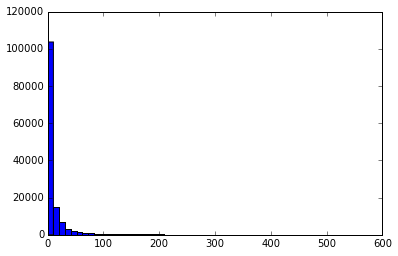

In [43]:
recs = data['Recommendations'].values
recs = np.nan_to_num(recs)
plt.hist(recs, bins=300)
plt.xlim(0,600)

In [55]:
columns = ['EditorPick', 'Sentiment_sent', 'Subjectivity_sent', 'word_count', 'Rec']
reg = data[columns]  

In [57]:
X = reg.drop('Rec', axis = 1).values
X = np.nan_to_num(X)
y = reg['Rec'].values

In [58]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

In [59]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)
# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)
# print 'Accuracy: %f'%(metrics.accuracy_score(y_test, y_pred))
rf.fit(X, y)
rf.oob_score_

0.58225765088049242

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140376 entries, 0 to 140375
Data columns (total 18 columns):
Unnamed: 0             140376 non-null int64
Comment                140371 non-null object
URL                    140371 non-null object
Recommendations        140371 non-null float64
Locations              140368 non-null object
EditorPick             140376 non-null int64
userID                 140371 non-null float64
date                   140368 non-null float64
Sentiment              140376 non-null float64
Sentiment_sent         140376 non-null float64
Sentiment_b            140376 non-null int64
Sentiment_b_sent       140376 non-null int64
Subjectivity           140376 non-null float64
Subjectivity_sent      140376 non-null float64
Subjectivity_b         140376 non-null int64
Subjectivity_b_sent    140376 non-null int64
State                  72003 non-null object
City                   112594 non-null object
dtypes: float64(7), int64(6), object(5)
memory usage: 20.3+ M

In [66]:
reg['EditorPick'].unique()

array([  0.00000000e+00,   1.00000000e+00,              nan,
         4.12978320e+07,   1.67200350e+07,   5.27258820e+07])

In [ ]:
### Naives Bayes, SVM

In [20]:
commentOnly = data[['Comment', 'Rec']]

In [21]:
X = commentOnly['Comment']
y = commentOnly['Rec'].values
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

In [22]:
vectorizer = TfidfVectorizer(stop_words = 'english')

vectorized_X_train  = vectorizer.fit_transform(X_train)
vectorized_X_test = vectorizer.transform(X_test)

In [24]:
rf = RandomForestClassifier(n_estimators = 10)
rf.fit(vectorized_X_train, y_train)

y_pred = rf.predict(vectorized_X_test)
print 'Accuracy: %f'%(metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.544749


### Multi-Class prediction on comments belonging to candidates

In [50]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(vectorized_X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

y_pred = clf.predict(vectorized_X_test)

print 'Accuracy: %f'%(metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.193907


In [51]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
y_pred = OneVsRestClassifier(LinearSVC(random_state=0)).fit(vectorized_X_train, y_train).predict(vectorized_X_test)
print 'Accuracy: %f'%(metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.183293


In [54]:
vectorizer = CountVectorizer(stop_words = 'english')
train_data_features = vectorizer.fit_transform(X_train)
train_data_features = train_data_features.toarray()

test_data_features = vectorizer.fit_transform(X_test)
test_data_features = test_data_features.toarray()

y_pred = OneVsRestClassifier(LinearSVC(random_state=0)).fit(vectorized_X_train, y_train).predict(vectorized_X_test)
print 'Accuracy: %f'%(metrics.accuracy_score(y_test, y_pred))

AttributeError: 'numpy.ndarray' object has no attribute 'lower'